In [1]:
from sys import byteorder
from array import array
from struct import pack
import numpy as np
import matplotlib
import math
import scipy

import pyaudio
import wave

THRESHOLD = 500
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
RATE = 44100

def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)

    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

def trim(snd_data):
    "Trim the blank spots at the start and end"
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)

            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

def add_silence(snd_data, seconds):
    "Add silence to the start and end of 'snd_data' of length 'seconds' (float)"
    r = array('h', [0 for i in xrange(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in xrange(int(seconds*RATE))])
    return r

def play(d):
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE, input=False, output=True, frames_per_buffer=CHUNK_SIZE)
    stream.write(d)
    stream.close()
    p.terminate()
    
def record(length=1.0):
    """
    Record a word or words from the microphone and 
    return the data as an array of signed shorts.

    Normalizes the audio, trims silence from the 
    start and end, and pads with 0.5 seconds of 
    blank sound to make sure VLC et al can play 
    it without getting chopped off.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    t = 0
    while t < int(length*RATE):
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)
        t += len(snd_data)

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

    #r = add_silence(r, 0.5)
    return sample_width, r

def record_to_file(path):
    "Records from the microphone and outputs the resulting data to 'path'"
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
    
def unzip(a):
    return ([x for (x,y) in a], [y for (x,y) in a])

In [2]:
import sample
import matplotlib.pyplot as plt

In [3]:
def plotter(path):
    x,y = sample.get_raw_data("data/{}".format(path))
    idx = 0
    while x[idx] < sample.BASE_CUTOFF:
        idx += 1
    x = x[idx:]
    y = y[idx:]
    plt.subplot(211)
    plt.plot(x,y,"-")
    x,y = sample.get_data("data/{}".format(path), 128)
    plt.subplot(212)
    plt.plot(x,y,"-")
    plt.show()

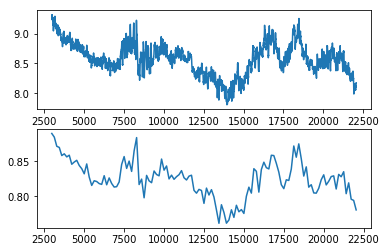

In [4]:
plotter("x-pad/0.wav")

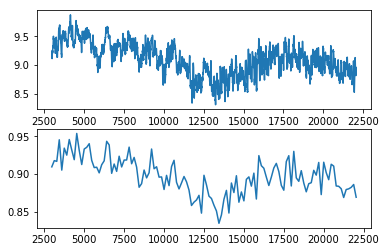

In [5]:
plotter("x-pad/4.wav")

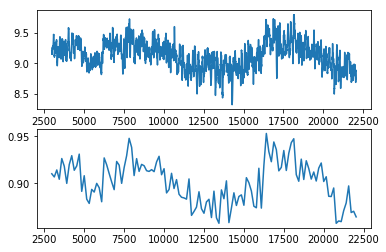

In [6]:
plotter("x-pad/6.wav")

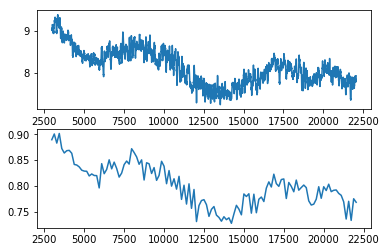

In [13]:
plotter("o-pad/3.wav")

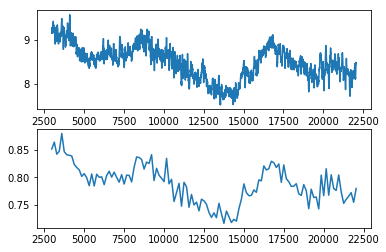

In [14]:
plotter("o-pad/8.wav")

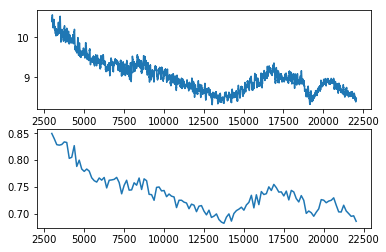

In [16]:
plotter("o-pad/14.wav")

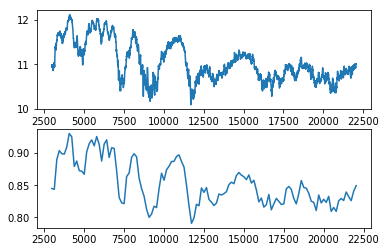

In [10]:
plotter("x-nail/7.wav")

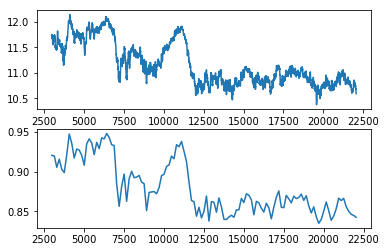

In [11]:
plotter("x-nail/10.wav")

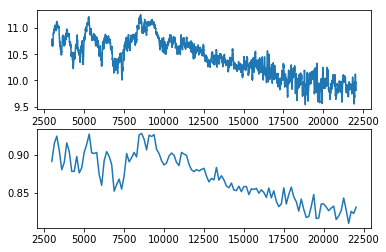

In [12]:
plotter("x-nail/14.wav")